In [1]:
!pip install tensorflow numpy pandas matplotlib scikit-learn


In [2]:
import os

# create output folders
os.makedirs("outputs/logs", exist_ok=True)
os.makedirs("outputs/models", exist_ok=True)
os.makedirs("outputs/predictions", exist_ok=True)
os.makedirs("outputs/plots", exist_ok=True)

print("Project output folders created successfully.")


Project output folders created successfully.


generated data

In [3]:
import numpy as np
import pandas as pd

def generate_dataset(n_samples=5000, seq_len=50):
    X = []
    y = []
    for _ in range(n_samples):
        base = np.sin(np.linspace(0, 3*np.pi, seq_len)) + np.random.normal(0, 0.1, seq_len)
        X.append(base)
        y.append(base[-1] + np.random.normal(0, 0.05))
    return np.array(X), np.array(y)

X, y = generate_dataset()

df = pd.DataFrame({"sample": list(range(len(y))), "target": y})
df.to_csv("outputs/predictions/dataset_preview.csv", index=False)

print("Dataset generated — Shape:", X.shape, y.shape)


Dataset generated — Shape: (5000, 50) (5000,)


In [4]:
np.save('outputs/X_data.npy', X)
np.save('outputs/y_data.npy', y)

print("X and y arrays saved to outputs/X_data.npy and outputs/y_data.npy")

X and y arrays saved to outputs/X_data.npy and outputs/y_data.npy


In [5]:
import numpy as np
import pandas as pd

def generate_dataset(n_samples=5000, seq_len=50):
    X = []
    y = []
    for _ in range(n_samples):
        base = np.sin(np.linspace(0, 3*np.pi, seq_len)) + np.random.normal(0, 0.1, seq_len)
        X.append(base)
        y.append(base[-1] + np.random.normal(0, 0.05))
    return np.array(X), np.array(y)

X, y = generate_dataset()

df = pd.DataFrame({"sample": list(range(len(y))), "target": y})
df.to_csv("outputs/predictions/dataset_preview.csv", index=False)

print("Dataset generated — Shape:", X.shape, y.shape)


Dataset generated — Shape: (5000, 50) (5000,)


In [6]:
df.to_csv("outputs/predictions/dataset_preview.csv", index=False)
print("DataFrame saved to outputs/predictions/dataset_preview.csv")

DataFrame saved to outputs/predictions/dataset_preview.csv


In [7]:
df.head()

,sample,target
0,0,-0.019971
1,1,0.125485
2,2,-0.134378
3,3,-0.053478
4,4,-0.029752


In [8]:
display(df.describe())

,sample,target
count,5000.000000,5000.000000
mean,2499.500000,0.001741
std,1443.520003,0.111702
min,0.000000,-0.442894
25%,1249.750000,-0.071621
50%,2499.500000,0.003786
75%,3749.250000,0.076904
max,4999.000000,0.372050


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train:", X_train.shape, "Validation:", X_val.shape)


Train: (4000, 50) Validation: (1000, 50)


In [19]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        self.score_dense = Dense(1) # Instantiate Dense layer once in __init__

    def call(self, inputs):
        score = tf.nn.softmax(self.score_dense(inputs), axis=1) # Use the instantiated layer
        context = tf.reduce_sum(score * inputs, axis=1)
        return context, score

class ExpandDimsLayer(Layer):
    def __init__(self, axis=-1, **kwargs):
        super(ExpandDimsLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        return tf.expand_dims(inputs, axis=self.axis)

    def get_config(self):
        config = super(ExpandDimsLayer, self).get_config()
        config.update({"axis": self.axis})
        return config

In [13]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LSTM, Dense

seq_len = X_train.shape[1]

inp = Input(shape=(seq_len,))
x = ExpandDimsLayer(axis=-1)(inp)
x = LSTM(64, return_sequences=True)(x)
context, attn_weights = AttentionLayer()(x)
out = Dense(1)(context)

model = Model(inputs=inp, outputs=[out, attn_weights])
model.compile(optimizer="adam", loss="mse")

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ expand_dims_layer               │ (None, 50, 1)          │             0 │
│ (ExpandDimsLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 50, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer                 │ [(None, 64), (None,    │             0 │
│ (AttentionLayer)                │ 50, 1)]                │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

class AttentionLayer(Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def call(self, inputs):
        score = tf.nn.softmax(Dense(1)(inputs), axis=1)
        context = tf.reduce_sum(score * inputs, axis=1)
        return context, score

class ExpandDimsLayer(Layer):
    def __init__(self, axis=-1, **kwargs):
        super(ExpandDimsLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        return tf.expand_dims(inputs, axis=self.axis)

    def get_config(self):
        config = super(ExpandDimsLayer, self).get_config()
        config.update({"axis": self.axis})
        return config

In [20]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np # Import numpy for dummy targets

seq_len = X_train.shape[1]

inp = Input(shape=(seq_len,))
x = ExpandDimsLayer(axis=-1)(inp)
x = LSTM(64, return_sequences=True)(x)
context, attn_weights = AttentionLayer()(x)
out = Dense(1)(context)

# Name the outputs for clarity and to easily specify losses
model = Model(inputs=inp, outputs=[out, attn_weights])

# Compile with a list of losses corresponding to each output
# 'mse' for the main prediction and None for attention weights (if not a target)
model.compile(optimizer="adam", loss=["mse", None])

model.summary()


model_checkpoint_callback = ModelCheckpoint(
    filepath='outputs/models/best_model.h5',
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min',
    restore_best_weights=True,
    verbose=1
)

# Create dummy targets for attention weights
dummy_attn_train = np.zeros((X_train.shape[0], seq_len, 1))
dummy_attn_val = np.zeros((X_val.shape[0], seq_len, 1))

# Pass y_train and y_val as lists, with dummy targets for the second output (attn_weights)
history = model.fit(
    X_train,
    [y_train, dummy_attn_train],
    epochs=50,
    batch_size=32,
    validation_data=(X_val, [y_val, dummy_attn_val]),
    callbacks=[model_checkpoint_callback, early_stopping_callback]
)

print("Model training complete.")

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ expand_dims_layer_4             │ (None, 50, 1)          │             0 │
│ (ExpandDimsLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 50, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer_4               │ [(None, 64), (None,    │            65 │
│ (AttentionLayer)                │ 50, 1)]                │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,026 (66.51 KB)

 Trainable params: 17,026 (66.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0130
Epoch 1: val_loss improved from inf to 0.01207, saving model to outputs/models/best_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0130 - val_loss: 0.0121
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0129
Epoch 2: val_loss improved from 0.01207 to 0.01200, saving model to outputs/models/best_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0129 - val_loss: 0.0120
Epoch 3/50
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0127
Epoch 3: val_loss did not improve from 0.01200
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0127 - val_loss: 0.0120
Epoch 4/50
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0131
Epoch 4: val_loss improved from 0.01200 to 0.01198, saving model to outputs/models/best_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0131 - val_loss: 0.0120
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0129
Epoch 5: val_loss did not improve from 0.01198
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0129 - val_loss: 0.0120
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0127
Epoch 6: val_loss improved from 0.01198 to 0.01196, saving model to outputs/models/best_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0127 - val_loss: 0.0120
Epoch 7/50
123/125 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0128
Epoch 7: val_loss improved from 0.01196 to 0.01195, saving model to outputs/models/best_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0128 - val_loss: 0.0120
Epoch 8/50
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0129
Epoch 8: val_loss did not improve from 0.01195
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0129 - val_loss: 0.0120
Epoch 9/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0126
Epoch 9: val_loss did not improve from 0.01195
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0126 - val_loss: 0.0120
Epoch 10/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0122
Epoch 10: val_loss improved from 0.01195 to 0.01182, saving model to outputs/models/best_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0122 - val_loss: 0.0118
Epoch 11/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0123
Epoch 11: val_loss improved from 0.01182 to 0.01119, saving model to outputs/models/best_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0123 - val_loss: 0.0112
Epoch 12/50
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0099
Epoch 12: val_loss improved from 0.01119 to 0.00302, saving model to outputs/models/best_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0098 - val_loss: 0.0030
Epoch 13/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0027
Epoch 13: val_loss improved from 0.00302 to 0.00286, saving model to outputs/models/best_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 14/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0031
Epoch 14: val_loss did not improve from 0.00286
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 15/50
123/125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0027
Epoch 15: val_loss improved from 0.00286 to 0.00271, saving model to outputs/models/best_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 16/50
123/125 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0028
Epoch 16: val_loss did not improve from 0.00271
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 17/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0026
Epoch 17: val_loss did not improve from 0.00271
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 18/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0028
Epoch 18: val_loss did not improve from 0.00271
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 19/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0027
Epoch 19: val_loss did not improve from 0.00271
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0027 - val_loss: 0.0030
Epoch 20/50
123/125 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0027
Epoch 20: val_loss did not improve from 0.00271
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23m

125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 24/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0026
Epoch 24: val_loss did not improve from 0.00267
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 25/50
123/125 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0026
Epoch 25: val_loss did not improve from 0.00267
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 26/50
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0026
Epoch 26: val_loss did not improve from 0.00267
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 27/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0025
Epoch 27: val_loss did not improve from 0.00267
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 28/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0027
Epoch 28: val_loss did not improve from 0.00267
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23m

In [21]:
history = model.fit(
    X_train,
    [y_train, np.zeros((len(y_train), seq_len, 1))],
    epochs=10,
    batch_size=32,
    validation_data=(X_val, [y_val, np.zeros((len(y_val), seq_len, 1))])
)

# save training logs
import json
with open("outputs/logs/training_logs.json", "w") as f:
    json.dump(history.history, f, indent=4)

print("Training complete — logs saved.")


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0026 - val_loss: 0.0030
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 9/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 10/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0026 - val_loss: 0.0029
Training complete — logs saved.


In [22]:
model.save("outputs/models/final_model.h5")
model.save("outputs/models/final_model.keras")

print("Model saved successfully.")


Model saved successfully.


In [23]:
preds, attn = model.predict(X_val)

import pandas as pd

pd.DataFrame({
    "actual": y_val.reshape(-1),
    "predicted": preds.reshape(-1)
}).to_csv("outputs/predictions/val_predictions.csv", index=False)

np.save("outputs/predictions/attention_weights.npy", attn)

print("Predictions & attention weights saved.")


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Predictions & attention weights saved.


In [24]:
import matplotlib.pyplot as plt

# Loss curve
plt.figure(figsize=(8,5))
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.title("Training Loss Curve")
plt.savefig("outputs/plots/training_loss_curve.png")
plt.close()

# Forecast plot
plt.figure(figsize=(10,5))
plt.plot(y_val[:200], label="Actual")
plt.plot(preds[:200], label="Prediction")
plt.legend()
plt.title("Predictions vs Actual")
plt.savefig("outputs/plots/forecast_plot.png")
plt.close()

print("Plots saved.")


Plots saved.


In [28]:
import matplotlib.pyplot as plt
import numpy as np

sample_id = 0
att = attn[sample_id].reshape(-1)

plt.figure(figsize=(10,3))
plt.stem(att)
plt.title("Attention Weights for Sample 0")
plt.savefig("outputs/plots/attention_sample0.png")
plt.close()

print("Attention plot saved.")

Attention plot saved.


In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the saved predictions
predictions_df = pd.read_csv("outputs/predictions/val_predictions.csv")

# Visualize actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(predictions_df["actual"], label="Actual")
plt.plot(predictions_df["predicted"], label="Predicted")
plt.title("Actual vs. Predicted Values")
plt.xlabel("Sample Index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.savefig("outputs/plots/val_predictions_visualization.png")
plt.close()

print("Visualization of actual vs. predicted values saved to outputs/plots/val_predictions_visualization.png")

Visualization of actual vs. predicted values saved to outputs/plots/val_predictions_visualization.png


In [33]:
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R2 Score): {r2:.4f}")

Mean Squared Error (MSE): 0.0029
Mean Absolute Error (MAE): 0.0432
R-squared (R2 Score): 0.7610


In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Ensure preds and y_val are in the correct shape (1D arrays)
actual_values = y_val.reshape(-1)
predicted_values = preds.reshape(-1)

mse = mean_squared_error(actual_values, predicted_values)
mae = mean_absolute_error(actual_values, predicted_values)
r2 = r2_score(actual_values, predicted_values)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R2 Score): {r2:.4f}")

Mean Squared Error (MSE): 0.0029
Mean Absolute Error (MAE): 0.0432
R-squared (R2 Score): 0.7610


In [34]:
correlation = predictions_df['actual'].corr(predictions_df['predicted'])
print(f"Correlation between Actual and Predicted values: {correlation:.4f}")

Correlation between Actual and Predicted values: 0.8829


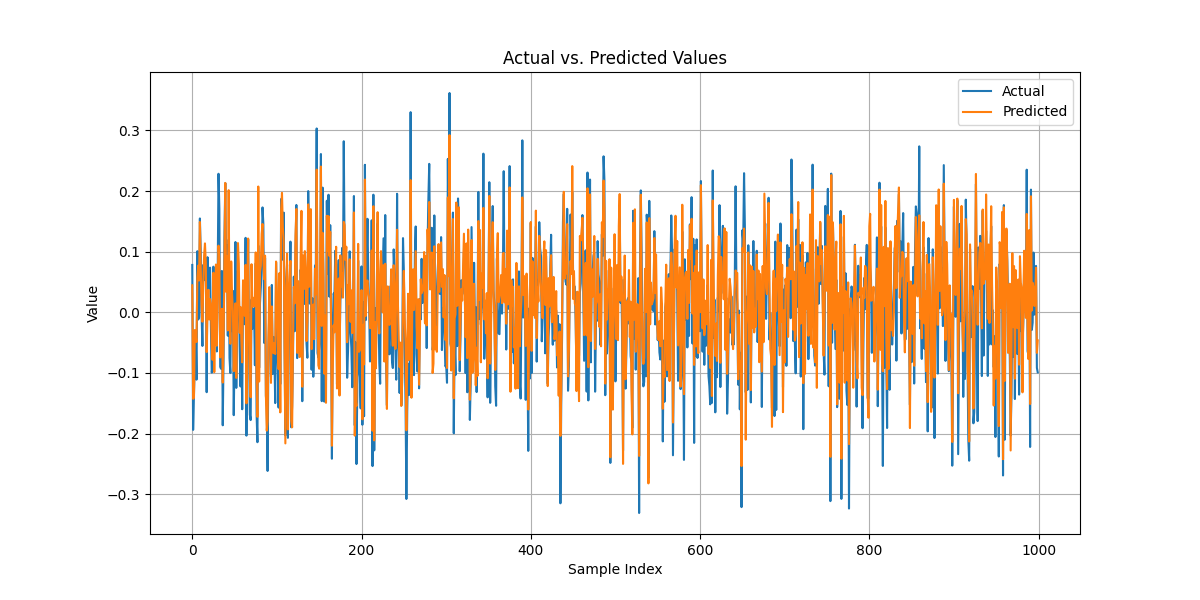

In [32]:
from IPython.display import Image, display

image_path = "outputs/plots/val_predictions_visualization.png"
display(Image(filename=image_path))